# **Importing Libraries**

In [21]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix, classification_report


# === IMAGE PARAMETERS ===
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20

# **V1 (With Image Augmentation Only)**

##  **Loading the Images**

In [2]:
# === SET PATH ===
dataset_path = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"  # Change this to your dataset directory
output_dir = "/kaggle/working/split_dataset"  # Directory to store train, val, test split
os.makedirs(output_dir, exist_ok=True)

# === CREATING TRAIN, VALIDATION, TEST SPLIT ===
all_images = []
all_labels = []

for class_name in os.listdir(dataset_path):  
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            all_images.append(img_path)
            all_labels.append(class_name)

df = pd.DataFrame({"image": all_images, "label": all_labels})

# Split dataset: 70% Train, 15% Val, 15% Test
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

In [3]:
# === IMAGE DATA GENERATORS WITH AUGMENTATION ===
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # ResNet50 specific preprocessing
    rotation_range=20,        # Random rotation (0-20 degrees)
    width_shift_range=0.2,    # Random width shift (20% of width)
    height_shift_range=0.2,   # Random height shift (20% of height)
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True      # Random horizontal flip
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # No augmentation for val/test

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="image",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col="image",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col="image",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False  # Important for evaluation
)

Found 7467 validated image filenames belonging to 4 classes.
Found 2489 validated image filenames belonging to 4 classes.
Found 2490 validated image filenames belonging to 4 classes.


## **Display some Images and Class Distribution** 

In [4]:
def show_images(path,title,cmap=None):
    labels = list(os.listdir(path))
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
    random_indices = random.sample(range(1, 101), 10)

    for i, idx in enumerate(random_indices, 1):
        file_path = os.path.join(path, labels[idx])
        image = Image.open(file_path)
        subplot_row = (i - 1) // 5
        subplot_col = (i - 1) % 5
        axes[subplot_row, subplot_col].imshow(image, cmap=cmap)
        axes[subplot_row, subplot_col].axis('off')
    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

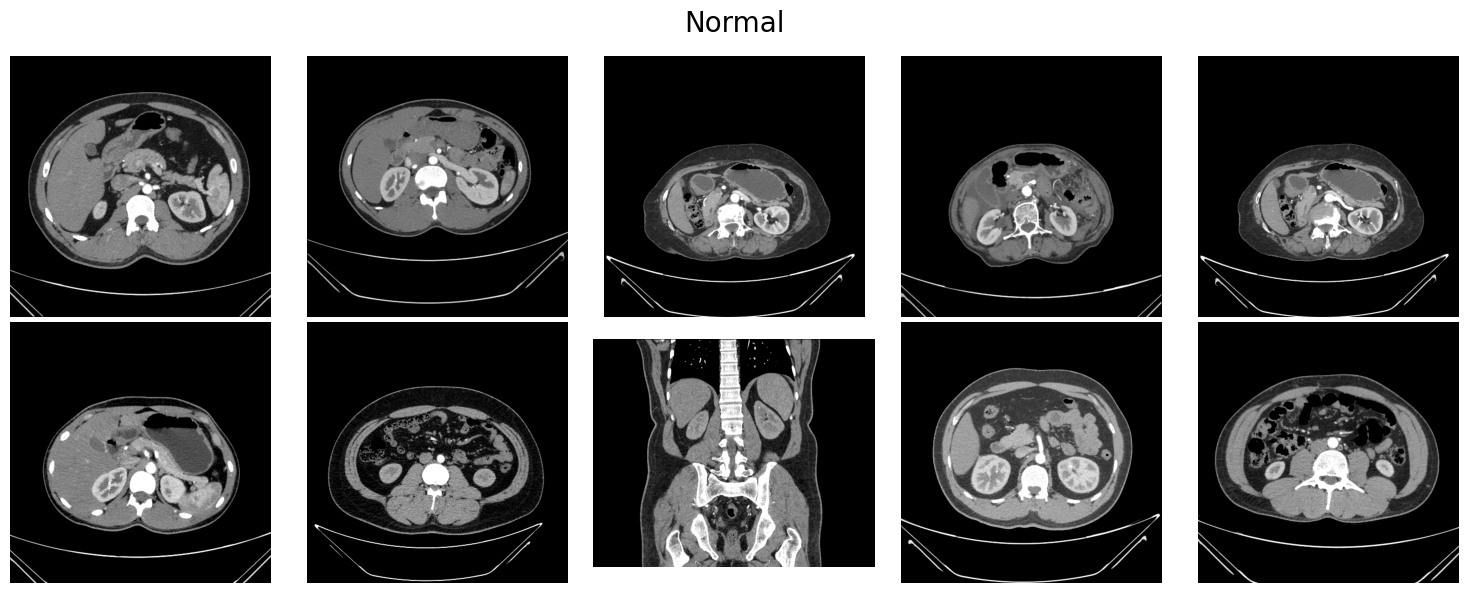

In [5]:
# Healthy Kidney
show_images(os.path.join(dataset_path+"/Normal"),"Normal")

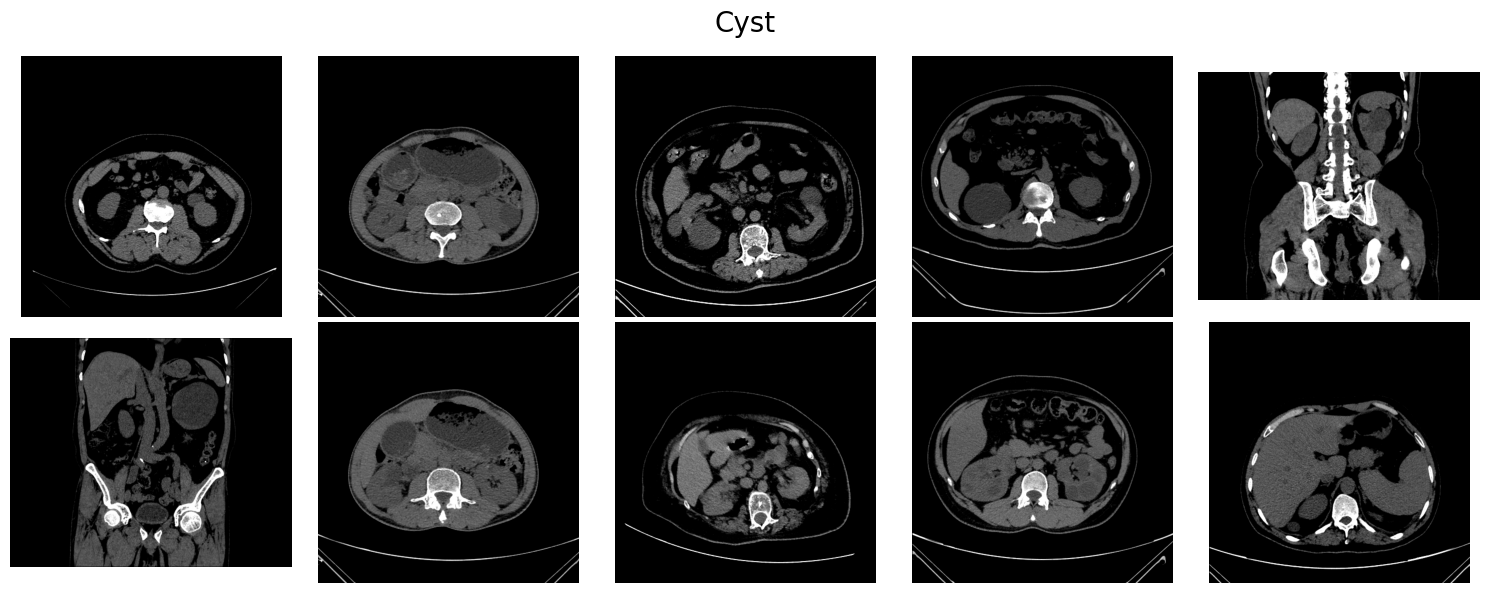

In [6]:
# Cyst
show_images(os.path.join(dataset_path+"/Cyst"),"Cyst")

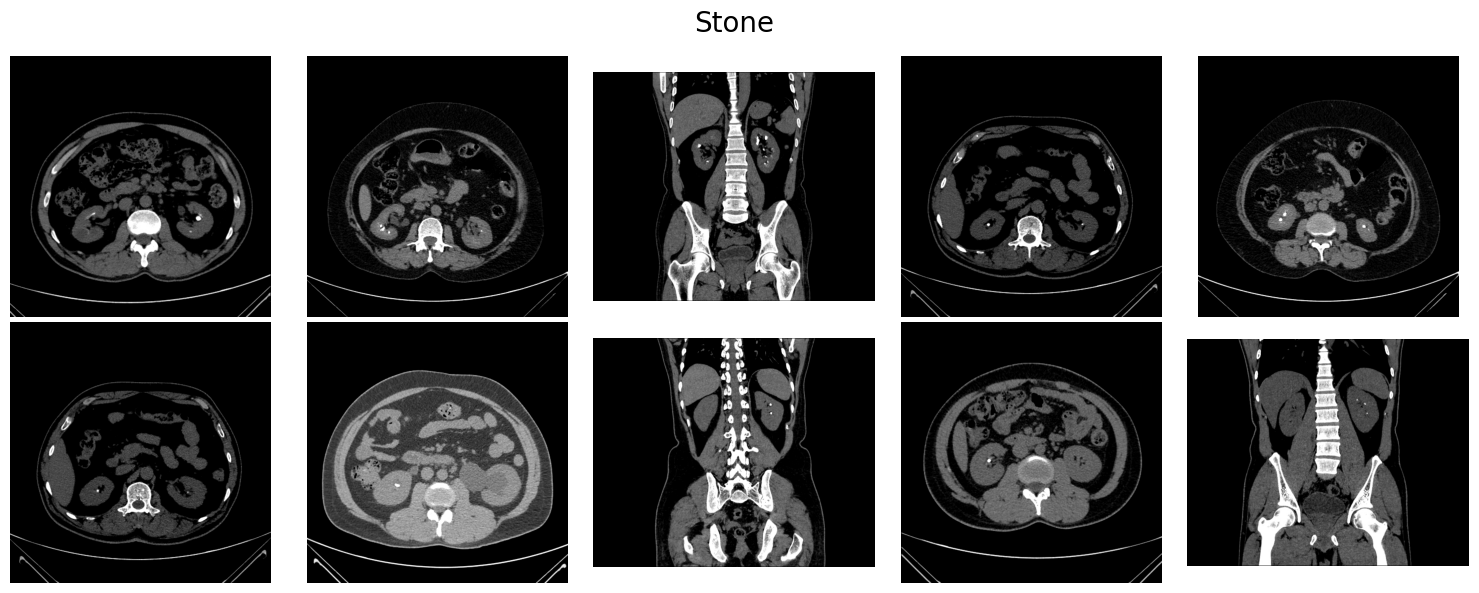

In [7]:
# Stone
show_images(os.path.join(dataset_path+"/Stone"),"Stone")

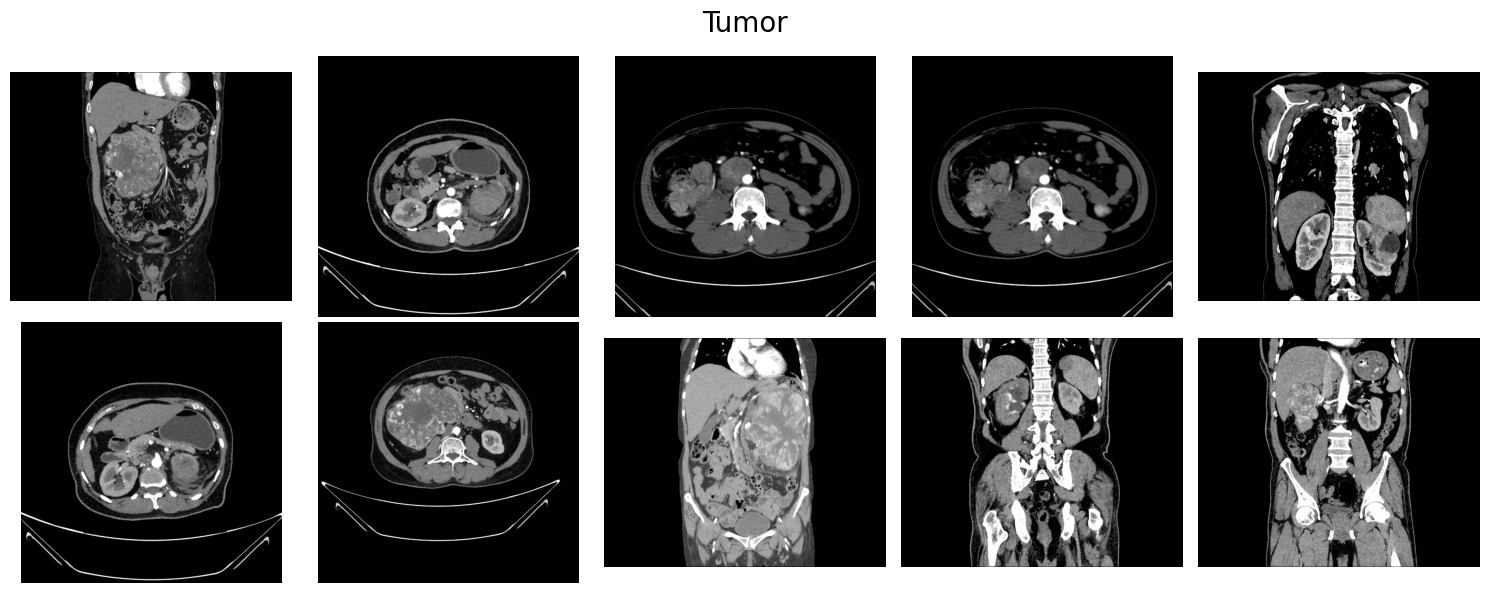

In [8]:
# Tumor
show_images(os.path.join(dataset_path+"/Tumor"),"Tumor")

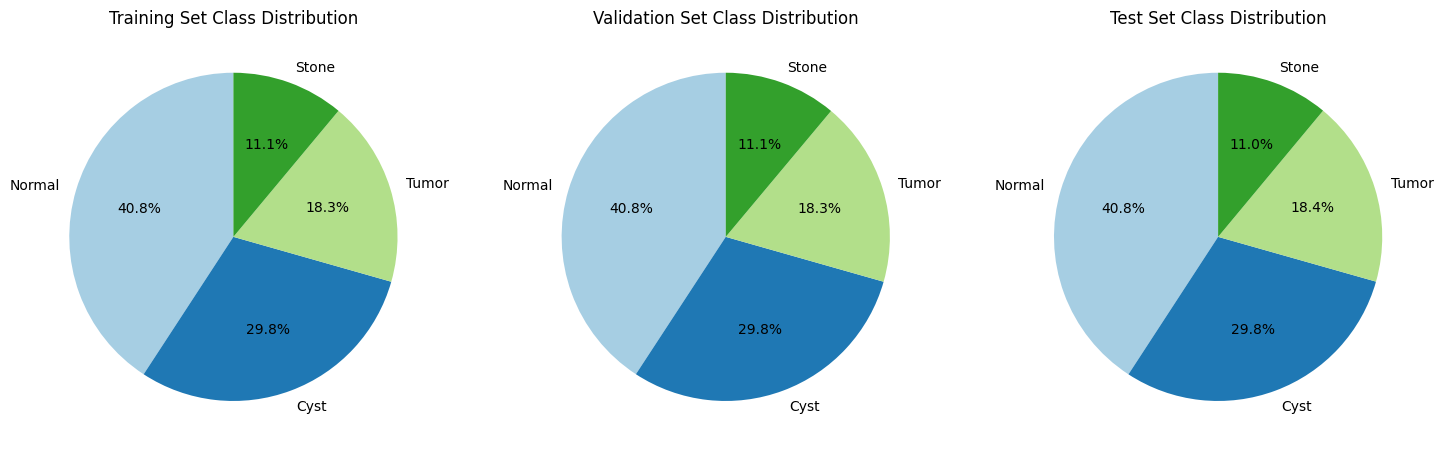

In [9]:
# === PLOT CLASS DISTRIBUTION ===
def plot_class_distribution(df, title, subplot_idx):
    class_counts = df["label"].value_counts()
    plt.subplot(1, 3, subplot_idx)
    plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    plt.title(title)

plt.figure(figsize=(18, 6))
plot_class_distribution(train_df, "Training Set Class Distribution", 1)
plot_class_distribution(val_df, "Validation Set Class Distribution", 2)
plot_class_distribution(test_df, "Test Set Class Distribution", 3)
plt.show()

## **Resnet50 Model** 

In [10]:
# === LOAD RESNET50 MODEL ===
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# === FREEZE BASE LAYERS ===
for layer in base_model.layers:
    layer.trainable = False  # Freeze all layers initially

# === ADD CUSTOM LAYERS ===
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Dense(len(df["label"].unique()), activation="softmax")(x)  # Output layer with # of classes

# === CREATE FINAL MODEL ===
model = Model(inputs=base_model.input, outputs=x)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# Define Callbacks
lr_callback = callbacks.ReduceLROnPlateau(monitor = 'val_recall', factor = 0.1, patience = 5)
stop_callback = callbacks.EarlyStopping(monitor = 'val_recall', patience = 5)

In [12]:
# === COMPILE MODEL ===
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)

In [13]:
# === TRAIN MODEL ===
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks = [lr_callback, stop_callback]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


234/234 ━━━━━━━━━━━━━━━━━━━━ 245s 951ms/step - accuracy: 0.6151 - loss: 0.9593 - precision: 0.7456 - recall: 0.4554 - val_accuracy: 0.7983 - val_loss: 0.5432 - val_precision: 0.8270 - val_recall: 0.7605 - learning_rate: 1.0000e-04
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 121s 504ms/step - accuracy: 0.8448 - loss: 0.4409 - precision: 0.8720 - recall: 0.8018 - val_accuracy: 0.8489 - val_loss: 0.4099 - val_precision: 0.8734 - val_recall: 0.8341 - learning_rate: 1.0000e-04
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 122s 506ms/step - accuracy: 0.8847 - loss: 0.3168 - precision: 0.9059 - recall: 0.8638 - val_accuracy: 0.8534 - val_loss: 0.4267 - val_precision: 0.8701 - val_recall: 0.8341 - learning_rate: 1.0000e-04
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 117s 487ms/step - accuracy: 0.9104 - loss: 0.2565 - precision: 0.9240 - recall: 0.8970 - val_accuracy: 0.9004 - val_loss: 0.2822 - val_precision: 0.9110 - val_recall: 0.8887 - learning_rate: 1.0000e-04
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 125

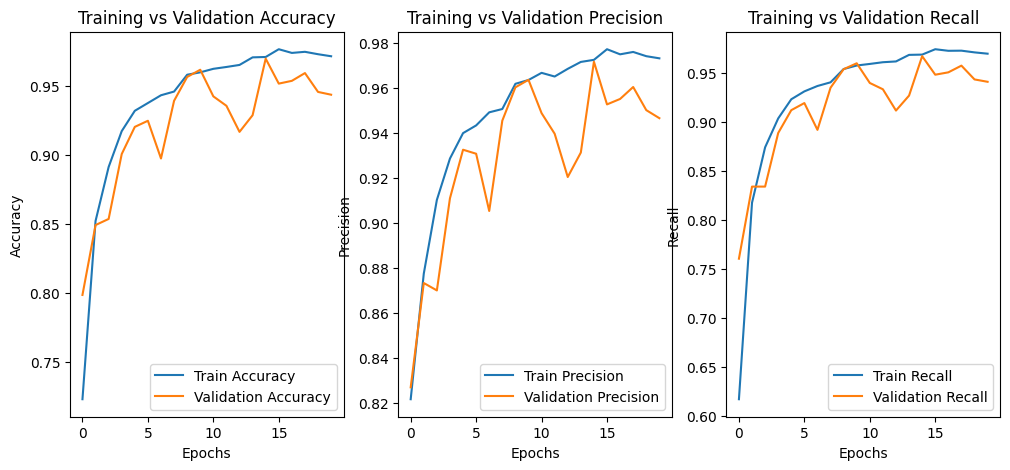

In [14]:
# === PLOT TRAINING HISTORY ===
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

# Precision plot
plt.subplot(1, 3, 2)
plt.plot(history.history["precision"], label="Train Precision")
plt.plot(history.history["val_precision"], label="Validation Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()
plt.title("Training vs Validation Precision")

# Recall plot
plt.subplot(1, 3, 3)
plt.plot(history.history["recall"], label="Train Recall")
plt.plot(history.history["val_recall"], label="Validation Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend()
plt.title("Training vs Validation Recall")

plt.show()

In [15]:
# === EVALUATE MODEL ON TEST DATA ===
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 37s 477ms/step - accuracy: 0.9382 - loss: 0.1729 - precision: 0.9398 - recall: 0.9372
Test Accuracy: 0.9361
Test Precision: 0.9383
Test Recall: 0.9349


In [18]:
# === CLASSIFICATION REPORT ===
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step
Classification Report:
              precision    recall  f1-score   support

        Cyst       0.88      1.00      0.93       742
      Normal       0.99      0.94      0.96      1016
       Stone       0.83      0.80      0.82       275
       Tumor       0.99      0.91      0.95       457

    accuracy                           0.94      2490
   macro avg       0.92      0.91      0.92      2490
weighted avg       0.94      0.94      0.94      2490



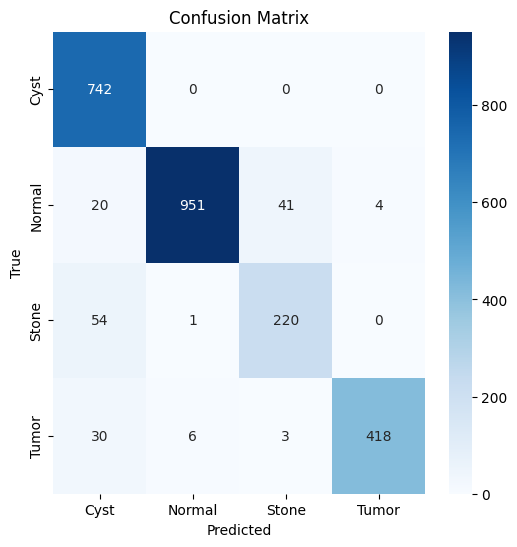

In [22]:
# === CONFUSION MATRIX ===
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [23]:
# === SAVE MODEL ===
model.save("resnet50_kidney_ct.h5")

# **V2 (Add Class weights to handle class imbalance)**

In [24]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks

# === IMAGE PARAMETERS ===
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20

In [25]:
# === SET PATH ===
dataset_path = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"  # Change this to your dataset directory

In [26]:
# === CREATE DATAFRAME WITH IMAGE PATHS AND LABELS ===
all_images = []
all_labels = []

for class_name in os.listdir(dataset_path):  
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            all_images.append(img_path)
            all_labels.append(class_name)

df = pd.DataFrame({"image": all_images, "label": all_labels})

In [27]:
# Compute class weights
y_labels = df["label"].values
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_labels), y=y_labels)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

In [28]:
# Split dataset: 60% Train, 20% Val, 20% Test
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

In [29]:
# === IMAGE DATA GENERATORS WITH AUGMENTATION ===
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # ResNet50 specific preprocessing
    rotation_range=20,        # Random rotation (0-20 degrees)
    width_shift_range=0.2,    # Random width shift (20% of width)
    height_shift_range=0.2,   # Random height shift (20% of height)
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True      # Random horizontal flip
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # No augmentation for val/test

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="image",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col="image",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col="image",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False  # Important for evaluation
)

Found 7467 validated image filenames belonging to 4 classes.
Found 2489 validated image filenames belonging to 4 classes.
Found 2490 validated image filenames belonging to 4 classes.


In [30]:
# === LOAD RESNET50 MODEL ===
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# === FREEZE BASE LAYERS ===
for layer in base_model.layers:
    layer.trainable = False  # Freeze all layers initially

# === ADD CUSTOM LAYERS ===
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Dense(len(df["label"].unique()), activation="softmax")(x)  # Output layer with # of classes

# === CREATE FINAL MODEL ===
model = Model(inputs=base_model.input, outputs=x)

In [31]:
# Define Callbacks
lr_callback = callbacks.ReduceLROnPlateau(monitor = 'val_recall', factor = 0.1, patience = 5)
stop_callback = callbacks.EarlyStopping(monitor = 'val_recall', patience = 5)

In [32]:
# === COMPILE MODEL WITH PRECISION & RECALL METRICS ===
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)

In [33]:
# === TRAIN MODEL WITH CLASS WEIGHTS ===
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks = [lr_callback, stop_callback]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


234/234 ━━━━━━━━━━━━━━━━━━━━ 144s 559ms/step - accuracy: 0.5036 - loss: 1.1200 - precision: 0.6268 - recall: 0.2264 - val_accuracy: 0.7750 - val_loss: 0.6097 - val_precision: 0.8243 - val_recall: 0.7127 - learning_rate: 1.0000e-04
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 119s 494ms/step - accuracy: 0.8087 - loss: 0.5342 - precision: 0.8499 - recall: 0.7504 - val_accuracy: 0.8353 - val_loss: 0.4401 - val_precision: 0.8591 - val_recall: 0.8108 - learning_rate: 1.0000e-04
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 125s 516ms/step - accuracy: 0.8715 - loss: 0.3683 - precision: 0.8990 - recall: 0.8459 - val_accuracy: 0.8554 - val_loss: 0.3617 - val_precision: 0.8730 - val_recall: 0.8393 - learning_rate: 1.0000e-04
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 118s 489ms/step - accuracy: 0.8791 - loss: 0.3225 - precision: 0.9009 - recall: 0.8607 - val_accuracy: 0.8485 - val_loss: 0.4228 - val_precision: 0.8686 - val_recall: 0.8313 - learning_rate: 1.0000e-04
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 117

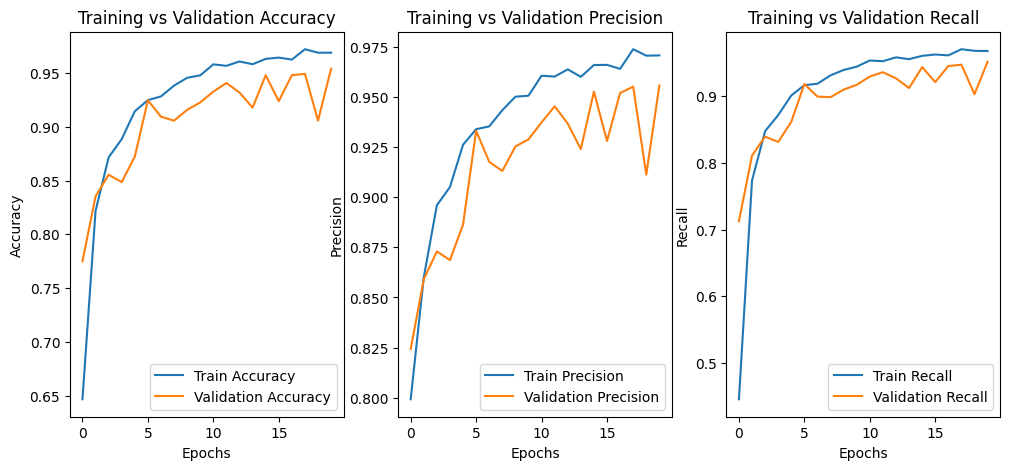

In [34]:
# === PLOT TRAINING HISTORY ===
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

# Precision plot
plt.subplot(1, 3, 2)
plt.plot(history.history["precision"], label="Train Precision")
plt.plot(history.history["val_precision"], label="Validation Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()
plt.title("Training vs Validation Precision")

# Recall plot
plt.subplot(1, 3, 3)
plt.plot(history.history["recall"], label="Train Recall")
plt.plot(history.history["val_recall"], label="Validation Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend()
plt.title("Training vs Validation Recall")

plt.show()

In [35]:
# === EVALUATE MODEL ON TEST DATA ===
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.9556 - loss: 0.1131 - precision: 0.9588 - recall: 0.9550
Test Accuracy: 0.9574
Test Precision: 0.9597
Test Recall: 0.9558


In [36]:
# === EVALUATE MODEL ON TEST DATA ===
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

78/78 ━━━━━━━━━━━━━━━━━━━━ 18s 196ms/step
Classification Report:
              precision    recall  f1-score   support

        Cyst       0.95      1.00      0.97       742
      Normal       0.99      0.94      0.96      1016
       Stone       0.94      0.89      0.91       275
       Tumor       0.92      0.97      0.94       457

    accuracy                           0.96      2490
   macro avg       0.95      0.95      0.95      2490
weighted avg       0.96      0.96      0.96      2490



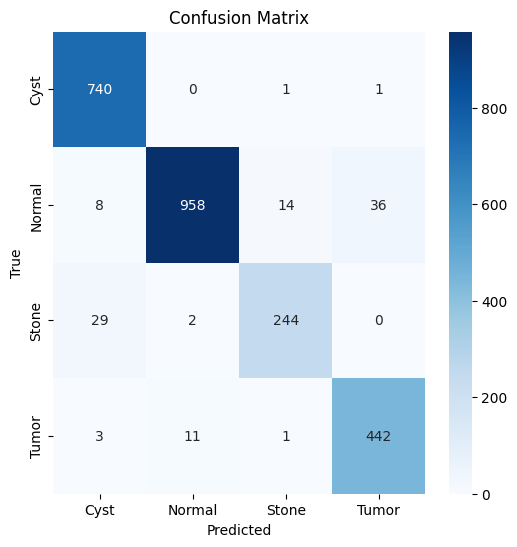

In [37]:
# === CONFUSION MATRIX ===
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [38]:
# === SAVE MODEL ===
model.save("resnet50_kidney_ct_augmented.h5")